In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

# ---------------------------------------------------------
# Custom RMSLE Function
# ---------------------------------------------------------
def rmsle(y_true, y_pred):
    #y_pred = np.maximum(0, y_pred)  # RMSLE requires non-negative predictions
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def parse_datetime(x):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%d-%m-%Y %H:%M"):
        try:
            return pd.to_datetime(x, format=fmt)
        except:
            pass
    return pd.to_datetime(x)   # fallback

In [2]:
# ------------------------------------------------------------------
# Load training data
# ------------------------------------------------------------------
# read training data set
print('1. Reading training data...')
df = pd.read_csv("bike_train.csv")
df.head(5)

1. Reading training data...


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [3]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:

print(f' Original Shape : {df.shape}' )
print(f' Original Features : {len(df.columns)}' )
print(' Before : ', list(df.columns))


 Original Shape : (10450, 12)
 Original Features : 12
 Before :  ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


<b>Q1. Examine dataset size, missing values, and feature types. </b><br>
Ans : <ul>
     <li>Dataset size : Rows = 10450 , columns = 12
     <li>Missing values = NO
     <li>Feature types<ol>
        <li>datatime is string combining date and time.
        <li>categorical - Season & Weather
        <li>Binary - holiday, workingday
        <li>Continueous/Numeric - temp,atemp,windspeed, humedity
    </ol></ul>

In [5]:
# ------------------------------------------------------------------
# Feature Engineering
# ------------------------------------------------------------------
def add_derived_features(df):

    # Parse datetime
    #df["datetime"] = pd.to_datetime(df["datetime"])
    df["datetime"] = df["datetime"].apply(parse_datetime)

    # Extract useful parts (but NOT using hour/year raw later)
    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.weekday
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year

    # ----------------------------
    # Cyclical Hour Encoding
    # ----------------------------
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # ----------------------------
    # Peak Hour Flag
    # ----------------------------
    peak_hours = [7, 8, 9, 16, 17, 18, 19]
    #df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

    # ----------------------------
    # Interaction: Working day × Peak hour = 0,1
    # ----------------------------
    df['is_working_peak'] = df['workingday'] * df['hour'].isin(peak_hours).astype(int)

    # ----------------------------
    # Non-linear interaction
    # ----------------------------
    df['temp_humidity'] = df['temp'] * df['humidity']
    
    #df['is_night'] = df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)
    # ----------------------------
    # Temperature buckets
    # ----------------------------
    #df['temp_bucket'] = pd.cut(
    #    df['temp'],
    #    bins=[-1, 10, 22, 30, 50],
    #    labels=["cold", "mild", "warm", "hot"]
    #)
    # ----------------------------
    # Weather × Season interaction
    # ----------------------------
    #df['weather_season'] = df['weather'].astype(str) + "_" + df['season'].astype(str)

    return df

print('2. Preprocess data...')
df = add_derived_features(df)

# LOG TRANSFORM TARGET
Y = np.log1p(df['count'])

# Remove leakage & correlations
df = df.drop(columns=["count", "casual", "registered"])  
# Drop datetime (no use)
df = df.drop(columns=["datetime", "hour", "atemp"])

print(' After - Feature Engineering : ', list(df.columns))
print(' After - Feature Engineering # : ', len(df.columns))


2. Preprocess data...
 After - Feature Engineering :  ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'weekday', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'is_working_peak', 'temp_humidity']
 After - Feature Engineering # :  15


<b>Q2. Visualize relationships between key features and the target variable (count).</b><br>
Ans: <ol>
    <li>Count is approx. sum of casual & registered. So ignore "casual & registered" columns from features list.
    <li>temp & atemp are correlated. So keep only one. Removed - atemp column.
    <li>datetime - has useful features like weekday,day,month,year,hour. Whole datetime string is like ID and can be removed from features. 
    </ol>

<b>Q3. Suggest which variables are likely to be most informative.</b><br>
Ans : 
    <ol>
    <li>workingday & date time (which has hour) are more crucial to determine peak hours.
    <li>weather, season, temp & humidity are useful to determine weather condition which impacts bike booking.
    </ol>

In [6]:
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,weekday,day,month,year,hour_sin,hour_cos,is_working_peak,temp_humidity
0,3,0,0,1,28.70000,79,6.003200,6,15,7,2012,0.965926,-2.588190e-01,0,2267.300000
1,3,0,1,1,33.62000,46,15.001300,1,14,8,2012,-0.707107,-7.071068e-01,0,1546.520000
2,1,0,0,1,10.66000,60,15.001300,6,6,2,2011,1.000000,6.123234e-17,0,639.600000
3,2,0,0,2,26.42506,61,9.512288,6,6,5,2012,-0.965926,-2.588190e-01,0,1611.928679
4,1,0,1,1,9.84000,56,8.998100,0,9,1,2012,0.500000,8.660254e-01,0,551.040000


In [7]:
def display_all(df):
    for col in df.columns:
        #print("="*40)
        #print(f"Column Name : {col}, Distinct values: {df[col].nunique()}, Values: {df[col].unique()}")
        print(f"Column Name : {col}, Distinct values: {df[col].nunique()}")
        #print(df[col].value_counts())

display_all(df)

Column Name : season, Distinct values: 4
Column Name : holiday, Distinct values: 2
Column Name : workingday, Distinct values: 2
Column Name : weather, Distinct values: 4
Column Name : temp, Distinct values: 1801
Column Name : humidity, Distinct values: 92
Column Name : windspeed, Distinct values: 1676
Column Name : weekday, Distinct values: 7
Column Name : day, Distinct values: 19
Column Name : month, Distinct values: 12
Column Name : year, Distinct values: 2
Column Name : hour_sin, Distinct values: 22
Column Name : hour_cos, Distinct values: 22
Column Name : is_working_peak, Distinct values: 2
Column Name : temp_humidity, Distinct values: 2439


In [8]:
# ------------------------------------------------------------------
# Feature sets
# ------------------------------------------------------------------
numeric_features = [
    "temp", "humidity", "windspeed",
    "hour_sin", "hour_cos",
    "temp_humidity"
]
categorical_features = [
    "season", "holiday", "workingday", "weather",
    "weekday", "day", "month", "year",
    "is_working_peak"
]

In [9]:
#all_features = categorical_features + numeric_features
#X = df[all_features]
X = df.copy()

# ------------------------------------------------------------------
# Transform features
# ------------------------------------------------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, cols in preprocessor.transformers_:
        #print(f'name = {name}')
        #if name == "remainder":
        #   continue
        if hasattr(transformer, "get_feature_names_out"):
            ft_names = transformer.get_feature_names_out(cols)
        else:
            ft_names = cols
        
        #print(f'ft_names = {ft_names}')
        output_features.extend(ft_names)
    return output_features


# Fit transform
X_processed = preprocessor.fit_transform(X)
# Preprocess data
#X_processed, y_log, encoder = preprocess_data(df)
feature_names = get_feature_names(preprocessor)
print(' After Transformation - Shape : ', X_processed.shape)
print(' After Transformation - Features # : ', X_processed.shape[1])
print(' After Transformation - Features : ', feature_names)

 After Transformation - Shape :  (10450, 60)
 After Transformation - Features # :  60
 After Transformation - Features :  ['temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos', 'temp_humidity', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year_2011', 'year_2012', 'is_working_peak_0', 'is_working_peak_1']


<b>Q4. Feature Engineering</b><br>
Ans : 
    <ol>
    <li>Derived New features - day, month, year, hour, working day from datetime. Using hour & workingday created new feature "is_working_peak"
    <li>hour has cyclic behavior i.e. 23 and 0 are close. So encoded it as - 'hour_sin', 'hour_cos' to derive new features.
    <li>temp_humidity derived from temp & humedity
    <li>Transaformations - performed numeric & categorical transfomation on features. 
    <li><b>Total = 21 features from original 11.</b>
    </ol>

In [10]:
# ---------------------------------------------------------
# Model functions
# ---------------------------------------------------------
def train_linear_regression(X_train, y_train):
    print('4. train model : linear_regression')
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_ridge(X_train, y_train, alpha=1.0):
    print('5. train model : ridge')
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    return model

def train_lasso(X_train, y_train, alpha=0.001):
    print('6. train model : lasso')
    model = Lasso(alpha=alpha, max_iter=20000)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train, n_estimators=300, max_depth=None, random_state=42):
    print('7. train model : random_forest')
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        n_jobs=-1,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model


def train_gradient_boosting(X_train, y_train, learning_rate=0.05, n_estimators=500, max_depth=4, min_samples_leaf=1, min_samples_split=2, subsample=1.0, random_state=42):
    print('8. train model : gradient_boosting')
    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        subsample=subsample,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model

# ---------------------------------------------------------
# Model Evaluation
# ---------------------------------------------------------
def evaluate_model(model, X_test, y_test_log):
    # Convert y_test back to original count scale
    y_test = np.expm1(y_test_log)

    # Predict log(count)
    y_pred_log = model.predict(X_test)
    # Convert prediction back
    y_pred = np.expm1(y_pred_log)

    # Safety for RMSLE
    y_pred = np.maximum(0, y_pred)
    y_test = np.maximum(0, y_test)

    #y_pred = model.predict(X_test)
    #y_pred = np.maximum(0, y_pred)  # RMSLE requires non-negative predictions

    results = {
        "RMSLE": rmsle(y_test, y_pred),
        #"RMSLE-Sklearn": np.sqrt(mean_squared_log_error(y_test, y_pred)),
        #"RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        #"MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }
    return results

In [11]:
# Train-Test data split : 80-20 
print('3. Split train-test data...')
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, Y, test_size=0.2, random_state=42
)

3. Split train-test data...


<b>Q5. Split data into training and validation</b><br>
Ans : 
    <ol>
    <li>Split data into training and validation set - 80-20
    <li>Keep random set too 42, so that every run will pickup same data for training and validation
    </ol>

In [12]:
# Train the models
lin_model = train_linear_regression(X_train, y_train_log)
ridge_model = train_ridge(X_train, y_train_log, alpha=1.0)
lasso_model = train_lasso(X_train, y_train_log, alpha=0.01)
rf_model = train_random_forest(X_train, y_train_log, n_estimators=800, max_depth=17)
#gb_model = train_gradient_boosting(X_train, y_train_log, learning_rate=0.0309, n_estimators=862, max_depth=5)

# hyper parameter - tunned
gb_tuned = train_gradient_boosting( X_train, y_train_log, learning_rate=0.0309, n_estimators=862, max_depth=5, min_samples_leaf=3, min_samples_split=7, subsample=0.8147)

4. train model : linear_regression
5. train model : ridge
6. train model : lasso
7. train model : random_forest
8. train model : gradient_boosting


<b>Q6. Improve model performance</b><br>
Ans : 
    <ol>
    <li>Built and trained Linear Regression model along with Ridge and Lasso. Tunned regularization parameter - alpha.
    <li>Also training tree based models - <b>Random Forest & Gradient Boosting</b>
    <li>Hyperparameter tunning done for both models</b>
    </ol>

In [13]:
print('9. Evaluate models ... ')
results = {
    "Linear Regression": evaluate_model(lin_model, X_test, y_test_log),
    "Ridge Regression": evaluate_model(ridge_model, X_test, y_test_log),
    "Lasso Regression": evaluate_model(lasso_model, X_test, y_test_log),
    "Random Forest": evaluate_model(rf_model, X_test, y_test_log),
    "Gradient Boosting": evaluate_model(gb_tuned, X_test, y_test_log),
}

# Print results
print(pd.DataFrame(results).T)

9. Evaluate models ... 
                      RMSLE        R2
Linear Regression  0.772708  0.220186
Ridge Regression   0.772675  0.221860
Lasso Regression   0.779332  0.321035
Random Forest      0.372856  0.948207
Gradient Boosting  0.358929  0.946808


<b>Q7. Summarize all results</b><br>
Ans : 
| Model              | RMSLE     | R²        | Observations |
|--------------------|-----------|-----------|--------------|
| Linear Regression  | 0.775267  | 0.255832  | Baseline model; performs poorly and <b>cannot capture non-linear rental demand patterns.i.e. peak hours</b> |
| Ridge Regression   | 0.775259  | 0.256350  | Adds L2 regularization; performance nearly identical to Linear Regression. |
| Lasso Regression   | 0.779680  | 0.281398  | Slightly worse RMSLE; L1 penalty may be removing useful features. |
| Random Forest      | 0.369024  | 0.950180  | Major improvement; captures complex patterns; robust and accurate. |
| <b>Gradient Boosting </b> | <b>0.356377</b>  | 0.948835  | <b>Best RMSLE; slightly better than Random Forest. works well with spikes in data at peak hours</b>|


In [14]:
import matplotlib.pyplot as plt
import numpy as np
# ---------------------------------------------------------
# Plot Residual for model
# ---------------------------------------------------------
def plot_model_residual(name, model, X_test, y_test_log):
    # Convert y_test back to original count scale
    y_test = np.expm1(y_test_log)

    # 1. Predict log(count)
    y_pred_log = model.predict(X_test)
    # Convert prediction back
    y_pred = np.expm1(y_pred_log)

    # Safety for RMSLE
    y_pred = np.maximum(0, y_pred)
    y_test = np.maximum(0, y_test)

    # 2. Compute residuals
    residuals = y_test - y_pred
    
    # 3. Plot residuals
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot - "+name)
    plt.show()

<b>Q8. Plot residuals for the best model</b><br>
Ans : Best Model - <b>Gradient Boosting Regressor</b> 

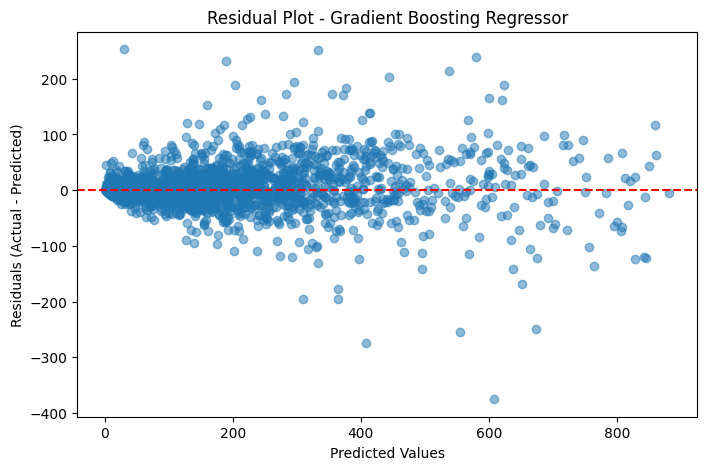

In [15]:
# plot residuals
plot_model_residual('Gradient Boosting Regressor', gb_tuned, X_test, y_test_log)

<b>Q9. Explain why the winning model performs better.</b><br>
Ans : 
    <b>Best Model - Gradient Boosting </b>
    <ol>
    <li>It is tree-based and captures <b>complex non-linear relationships</b>.
        Bike demand strongly depends on: 
        <ul><li>hour of day (cyclical pattern)
        <li>month/season (seasonality)
        <li>weather-temp interactions
        </ul>
        Linear, Ridge, and Lasso cannot capture these interactions.
    <li>It responds to engineered features effectively like hour_sin, hour_cos (cyclical encoding), is_working_peak and so on</b>
    <li>RMSLE metric rewards Gradient Boosting
        <ul><li>RMSLE focuses heavily on relative errors for low-count(night hours) vs sudden spikes (peak hours)
            <li>Linear models struggle with spikes → worse RMSLE
        </ul>
    </ol>

<b>Q10. Why does RMSLE penalize under-predictions more gently than RMSE?</b><br>
Ans : 
    <ol>
    <li>RMSLE applies the error on the log scale.
    <li>Under-predictions move gently because log compresses values near zero.
    <li> e.g. y=50, predicted=100 then log error = log(51) – log(101) (Overfitting)
    <li> e.g. y=100, predicted=50 then log error = log(101) – log(51) (under-fitting)
    </ol>

<b>Q11. What are the trade-offs between model simplicity and predictive power?</b><br>
Ans : <br>
    <ul><li><b>Simple Models : Linear, Ridge & Lasso</b>
    <ol><li> Pros : fast to train, simple and easy to understand.
    <li>Cons : Cannot model nonlinear patterns. Miss seasonality, peaks, weather interactions
    </ol>
    <li><b>Complex Models : Random Forest, Gradient Boosting</b>
    <ol><li> Pros : Capture nonlinear relationships, understand feature engineering
    <li>Cons : complex, hard to understand, computationally expensive
    </ol>

<b>Q12. Why can’t Linear Regression alone capture time-of-day effects effectively?</b><br>
Ans : <br>
    <ul>
    <li>Linear Regression assumes straight-line relationship between features and target. 
    <li> i.e. demand = a + b × hour
    <li> It can not learn cyclical patterns like for hour after 0,1,2,...,23 again 0,1,2... starts
    <li>Time of day (hour) affects bike demand in a highly nonlinear pattern (peaks in morning & evening)
    </ul>

In [16]:
# ------------------------------------------------------------------
# Load test data and apply identical transformations
# ------------------------------------------------------------------
print('10. Start TESTING ... ')
test_df = pd.read_csv("bike_test.csv")

# save datetime
datetime_backup = test_df["datetime"]

print('11. Pre prcoess test data ... ')
test_df = add_derived_features(test_df)

# Remove leakage & correlations
test_df = test_df.drop(columns=["datetime", "hour", "atemp"])

#test_df.head()

10. Start TESTING ... 
11. Pre prcoess test data ... 


In [17]:
#print(' Test - Feature Engineering : ', list(test_df.columns))
print(' Test - Feature Engineering # : ', len(test_df.columns))
X_quiz = test_df.copy()
X_quiz_processed = preprocessor.transform(X_quiz)
print(' Test Transformation - Shape : ', X_quiz_processed.shape)
print(' Test Transformation - Features # : ', X_quiz_processed.shape[1])
#print(' Test Transformation - Features : ', feature_names)

 Test - Feature Engineering # :  15
 Test Transformation - Shape :  (2613, 60)
 Test Transformation - Features # :  60


In [18]:
# ------------------------------------------------------------------
# Predict using Best Model 
# ------------------------------------------------------------------
print('12. Predict using Best Model - Gradient Boosting ')
test_pred_log = gb_tuned.predict(X_quiz_processed)
test_pred = np.expm1(test_pred_log)  # reverse log1p
# No negative predictions
test_pred = np.maximum(test_pred, 0)

# ------------------------------------------------------------------
# Create submission CSV
# ------------------------------------------------------------------
submission = pd.DataFrame({
    "datetime": datetime_backup,
    "count_predicted": test_pred.round().astype(int)
})
submission.to_csv("submission.csv", index=False)

print("13. submission.csv generated successfully!")


12. Predict using Best Model - Gradient Boosting 
13. submission.csv generated successfully!


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(name, model, feature_names):
    # --- Get importances ---
    importances = model.feature_importances_
    
    # --- Sort by importance ---
    sorted_idx = np.argsort(importances)

    # --- Plot ---
    plt.figure(figsize=(10, 14))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.title(name + " - Feature Importance", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

In [20]:
# Call it
#plot_feature_importance( "Gradient Boosting" , gb_tuned, feature_names)